In [38]:
from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion import *
from utils.utils_aha import *
import nibabel as nib
from skimage.util import montage
import matplotlib.pyplot as plt
import os

########################## Mask and normalization ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)


def get_mask(V, netS):
    nx, ny, nz, nt = V.shape

    M = np.zeros((nx, ny, nz, nt))
    v = V.transpose((2, 3, 0, 1)).reshape((-1, nx, ny))  # (nz*nt,nx,ny)
    v = normalize(v)
    for t in range(nt):
        for z in range(nz):
            m = netS(
                v[z * nt + t, nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64][
                    None, ..., None
                ]
            )
            M[nx // 2 - 64 : nx // 2 + 64, ny // 2 - 64 : ny // 2 + 64, z, t] += (
                np.argmax(m, -1).transpose((1, 2, 0)).reshape((128, 128))
            )
    return M

######################### Constants and arguments ######################################

DATASET_FOLDER = "ACDC"

class CarSON_options:
    def __init__(self):
        self.isTrain = False
        self.image_shape = (128, 128, 1)
        self.nlabels = 4
        self.pretrained_models_netS = "models/carson_Jan2021.h5"
        self.pretrained_models_netME = "models/carmen_Jan2021.h5"


class CarMEN_options:
    def __init__(self):
        self.isTrain = False
        self.volume_shape = (128, 128, 16, 1)
        self.pretrained_models_netS = "models/carson_Jan2021.h5"
        self.pretrained_models_netME = "models/carmen_Jan2021.h5"

In [41]:
opt = CarSON_options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netS = model.get_netS()

out_folder = "data/training/"
patients = [f"patient{i:03d}" for i in range(1, 101)]

for patient in patients:
    print(f"Segmentation on patient {patient}")
    V_nifti = nib.load(os.path.join(DATASET_FOLDER, patient, f"{patient}_4d.nii.gz"))
    V_nifti_resampled = resample_nifti(
        V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16
    )

    V = V_nifti_resampled.get_fdata()
    V = normalize(V, axis=(0, 1))
    M = get_mask(V, netS)

    center_resampled = center_of_mass(M[:, :, :, 0] == 2)
    V = base_dataset.roll_and_pad_256x256_to_center(x=V, center=center_resampled)
    M = base_dataset.roll_and_pad_256x256_to_center(x=M, center=center_resampled)
    center_resampled_256x256 = center_of_mass(M == 3)

    M = get_mask(V, netS)[128 - 64 : 128 + 64, 128 - 64 : 128 + 64]
    V = V[128 - 64 : 128 + 64, 128 - 64 : 128 + 64]

    M_nifti = nib.Nifti1Image(M, V_nifti_resampled.affine)
    V_nifti = nib.Nifti1Image(V, V_nifti_resampled.affine)

    M_nifti.to_filename(os.path.join(out_folder, f"{patient}_seg.nii.gz"))
    V_nifti.to_filename(os.path.join(out_folder, f"{patient}.nii.gz"))

Segmentation on patient patient001
Segmentation on patient patient002
Segmentation on patient patient003
Segmentation on patient patient004
Segmentation on patient patient005
Segmentation on patient patient006
Segmentation on patient patient007
Segmentation on patient patient008
Segmentation on patient patient009


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient010


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient011


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient012


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient013


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient014


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient015


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient016


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient017


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient018


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient019


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient020


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient021
Segmentation on patient patient022
Segmentation on patient patient023
Segmentation on patient patient024
Segmentation on patient patient025
Segmentation on patient patient026
Segmentation on patient patient027
Segmentation on patient patient028
Segmentation on patient patient029
Segmentation on patient patient030
Segmentation on patient patient031
Segmentation on patient patient032
Segmentation on patient patient033
Segmentation on patient patient034


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient035


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient036


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient037


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient038


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient039


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient040


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient041


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient042
Segmentation on patient patient043


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient044
Segmentation on patient patient045


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient046


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient047


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient048


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient049
Segmentation on patient patient050
Segmentation on patient patient051


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient052


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient053


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient054


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient055


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient056


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


Segmentation on patient patient057


/Users/yhibo/tensorflow-test/PIStrain/training/datasets/nifti_dataset.py:77: UserWarning: Affine in nifti might be set incorrectly. Setting to affine=affine*zooms
  warnings.warn("Affine in nifti might be set incorrectly. Setting to affine=affine*zooms")


(128, 128, 16, 30)

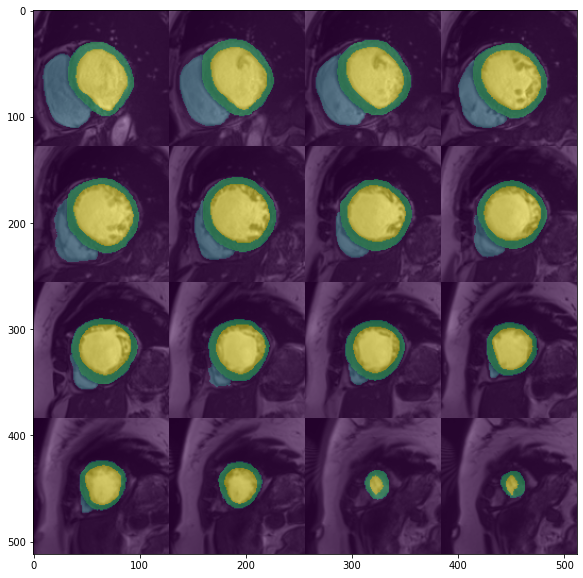

In [40]:
volume = V_nifti.get_fdata()
mask = M_nifti.get_fdata()
plt.figure(figsize=(10, 10))
plt.imshow(montage(volume[:, :, :, 0].transpose()), cmap="gray")
plt.imshow(montage(mask[:, :, :,0].transpose()), alpha=0.5)
M.shape

Data  that will be used for training is in ACDC folder

In [1]:
from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion import *
from utils.utils_aha import *
import nibabel as nib
from skimage.util import montage
import matplotlib.pyplot as plt

##########################      Normalization     ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)

######################### Constants and arguments ######################################

class CarMEN_options:
    def __init__(self):
        self.isTrain = True
        self.volume_shape = (128, 128, 16, 1)
        self.lambda_i = 0.1
        self.lambda_s = 0
        self.lambda_a = 0
